<h1><center>Clustering</center></h1>

<h2><center>By Alex Bradshaw</center></h2>

## 1. K-Means Clustering
### 1a. What is Clustering?
Clustering as it intuitively applies, groups the data into clusters. This is usually useful during unsupervised learning-where we don't have any ground truth labels for our data-but we want to group them into meaningful categories. This is also useful for data compression because it captures the general subject and ignores the minor details. For example, if we wanted to save a photo, but the photo has a huge amount of colors and takes up loads of memory, we could use clustering which would maintain the overall structure of the photo, but it maybe won't be as pretty as it was originally. Still better than losing the picture due to memory space!

### 1b. How do we cluster?
Lucky for us, people have already developed algorithms for clustering data. The most popular one by far is K-Means. Like the name suggests, this algorithm groups the data using a k mean points, usually referred to as centroids. The pseudo-code for that algorithm goes as follows. 

    Initialize k centroids
    while not satisfied:
        Compute distance from every point to each centroid
        Assign each point to closest centroid
        Move centroid to average cordinates of cluster

The not satisfied condition is typically when the centroids don't shift, but this can be adjusted to just be an iteration or when only a small number of points change when the centroids get updated. Here's a simple, very naive implementation and example with k=3 to cluster groups of 2D points and compress pictures.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.datasets import make_blobs
from sklearn.datasets import make_circles
try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face

    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)
from sklearn.datasets import load_iris, load_sample_image
warnings.filterwarnings('ignore')
np.random.seed(seed=17)

In [2]:
# Courtesy of Turner Luke 
# https://towardsdatascience.com/create-your-own-k-means-clustering-algorithm-in-python-d7d4c9077670
class KMeans:
    
    def euclidean(point, data):
        return np.sqrt(np.sum((point - data)**2, axis=1))

    def __init__(self, k, max_iter = 20):
        self.num_centroids = k
        self.max_iter = max_iter
        
    def init_centroids(self, X):
        min_, max_ = np.min(X, axis=0), np.max(X, axis=0)
        self.centroids = [np.random.randint(min_, max_,) for i in range(self.num_centroids)]
        
    def fit(self, X, is_image=False):
        np.random.seed(seed=17)
        # Formatting if X is an image and on greyscale
        h, w = X.shape[:2]
        dimension = 1
        if(X.ndim==3):
            dimension = X.shape[2]
        self.original_data = X.copy()
        if(is_image):
            X = X.reshape(h*w, dimension)
        self.init_centroids(X) # initialize k centroids
        i = 0
        prev_centroids = None
        # Clustering Begins
        while np.not_equal(self.centroids, prev_centroids).any() and i < self.max_iter: # not satisfied
            sorted_points = [[] for i in range(self.num_centroids)]
            for x in X:
                dists = KMeans.euclidean(x, self.centroids) # distance from point to all centroids
                centroid_idx = np.argmin(dists) # Get index of closest centroid
                sorted_points[centroid_idx].append(x) # Assign to appropriate cluster
            prev_centroids = self.centroids
            self.centroids = [np.mean(cluster, axis=0) for cluster in sorted_points] # Move centroid to average cords
            for j, centroid in enumerate(self.centroids):
                if np.isnan(centroid).any():
                    self.centroids[j] = prev_centroids[j]
            i += 1
        self.labels = []
        self.data_with_labels = []
        for x in X:
            dists = KMeans.euclidean(x, self.centroids)
            centroid_idx = np.argmin(dists)
            self.labels.append(centroid_idx)
            y = np.append(x, centroid_idx)
            self.data_with_labels.append(y)
        self.data_with_labels = np.array(self.data_with_labels)
        self.clusters = sorted_points
        self.centroids = np.array(self.centroids)
        
    def plot_clusters(self):
        plt.figure(figsize=(8,6))
        plt.scatter(self.data_with_labels[:,0], self.data_with_labels[:, 1],
                    c=self.data_with_labels[:, 2], cmap = 'spring')
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1],
                    c = 'black', s = 100, marker = '+', label = 'Centroids')
        plt.title(f'Clustering with {self.num_centroids} centroids')
        plt.legend()
    
    def recreate_image(self, is_bw = False):
        self.image = []
        for x in self.data_with_labels:
            self.image.append(np.int16(self.centroids[x[-1]]))
        plt.figure(figsize=(7,5))
        if(is_bw):
            plt.imshow(np.array(self.image).reshape(self.original_data.shape), cmap=plt.cm.gray)
        else:
            plt.imshow(np.array(self.image).reshape(self.original_data.shape))
        plt.title(f'Recreated Image with k={self.num_centroids}')
        plt.axis("off")
        plt.figure(figsize=(7,5))
        if(is_bw):
            plt.imshow(self.original_data, cmap=plt.cm.gray)
        else:
            plt.imshow(self.original_data)
        plt.title(f'Original Image')
        plt.axis("off")
        plt.show()
        
    def wcss(self):
        ss = 0
        for i in range(len(self.centroids)):
            centr = self.centroids[i]
            for j in self.clusters[i]:
                ss+=np.linalg.norm(centr-j)
        self.wcss = ss
        return ss

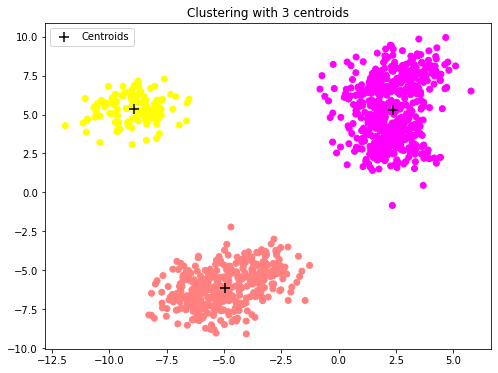

In [3]:
X_blob, y_blob = make_blobs(n_samples=1000, centers=8, n_features=2, random_state=171)
model_blobs = KMeans(3)
model_blobs.fit(X_blob)
model_blobs.plot_clusters()

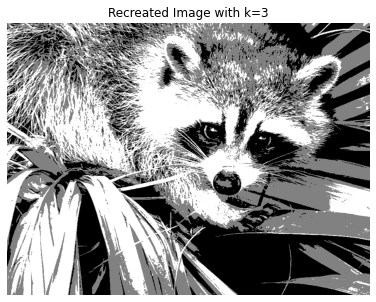

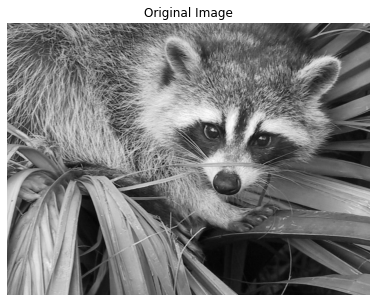

In [4]:
model_face = KMeans(3)
model_face.fit(face, is_image=True)
model_face.recreate_image(is_bw=True)

### 1c. Image Specifics
Colors with K-Means are slightly different because we need to reorganize the pixels in a way that recreates the original image. We can do that by turning the 2D matrix of pixels with a color value into a long list of just color "cordinates" that we can then cluster. Here is an example plot of what KMeans is doing to the pixels of the raccoon.

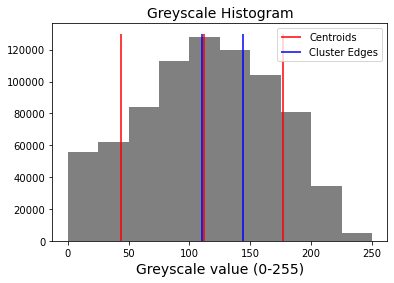

In [5]:
plt.hist(face.reshape(-1), color='gray')
plt.vlines([model_face.centroids], 0, 130000, color='red', label='Centroids')
plt.title('Greyscale Histogram', size = 14)
plt.vlines([(model_face.centroids[0]+model_face.centroids[1])/2,
           (model_face.centroids[1]+model_face.centroids[2])/2], 0, 130000, color='blue', label='Cluster Edges')
plt.xlabel('Greyscale value (0-255)', size = 14)
plt.legend()
plt.show()

We can see from this histogram what values of the greyscale our centroids landed at and where the split the pixels. Recreating images with K-Means uses the average greyscale value in each cluster as every point in that cluster. These values are then reshaped into the original size of the image in order to keep light pixels and dark pixels where they belong to create the original image with now only k colors. 

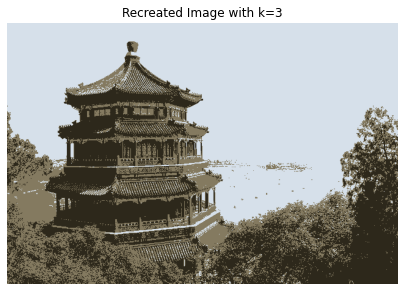

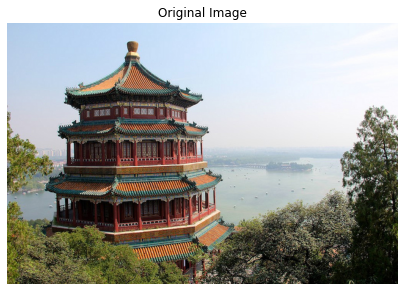

In [6]:
china = load_sample_image('china.jpg')
model_face = KMeans(3)
model_face.fit(china, is_image=True)
model_face.recreate_image()

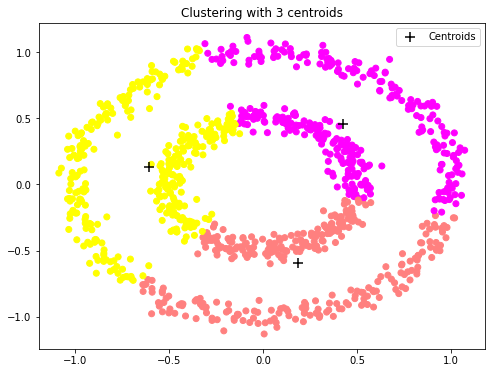

In [7]:
X_circle, y_circle = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=171)
model_blobs = KMeans(3)
model_blobs.fit(X_circle)
model_blobs.plot_clusters()

### 1d. Issues and Adjustments with K-means


As we can notice from the last plot, K-Means clustering doesn't work well with circular data. This is because K-Means slices the data space using the lines of equidistant points between each centroid to create convex regions.

Other problems that arise when using K-Means clustering is over or underfitting the data. This is a common issue because k is a hyperparameter and is not something optimized by the algorithm. 

Below are two examples.

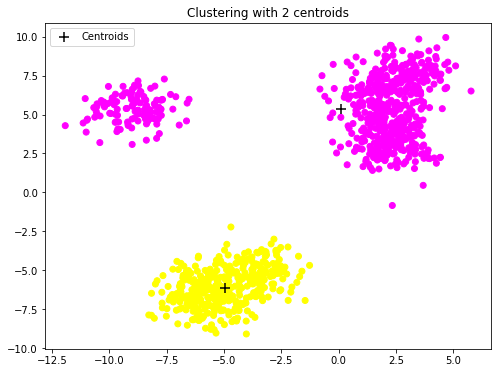

In [8]:
X_blob, y_blob = make_blobs(n_samples=1000, centers=8, n_features=2, random_state=171)
model_blobs = KMeans(2)
model_blobs.fit(X_blob)
model_blobs.plot_clusters()

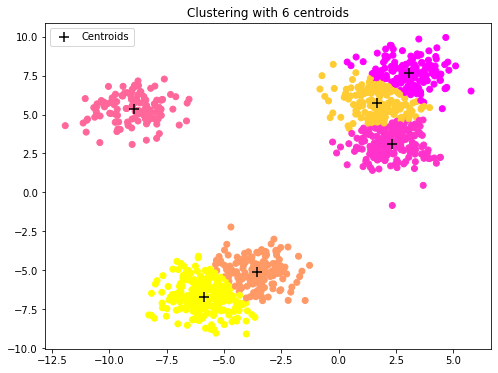

In [9]:
X_blob, y_blob = make_blobs(n_samples=1000, centers=8, n_features=2, random_state=171)
model_blobs = KMeans(6)
model_blobs.fit(X_blob)
model_blobs.plot_clusters()

We can see here there are three obvious big clusters of points and in both of these plots, the algorithm under and overfits the data. \
One of the ways we can choose an optimal k value to produce the most "cluster-like" clusters, is by using the elbow method. 

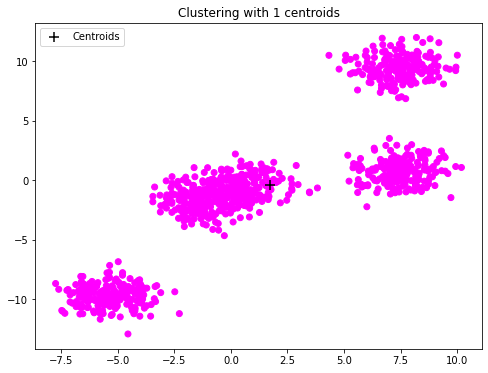

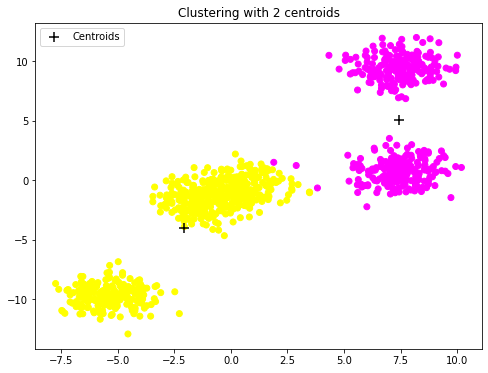

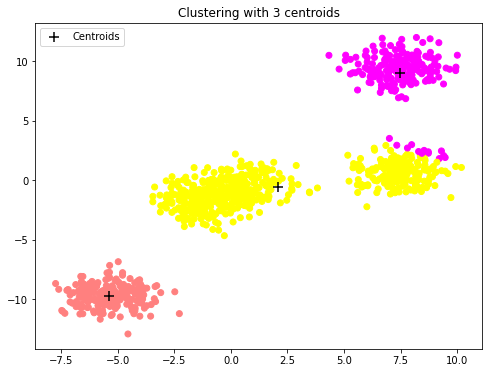

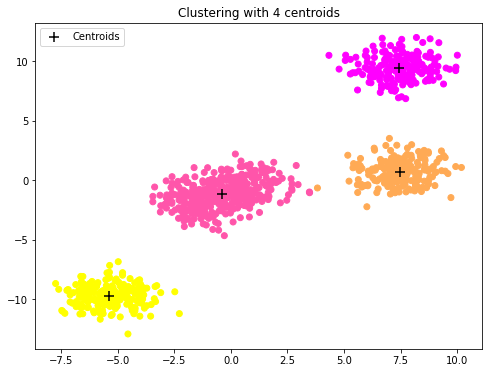

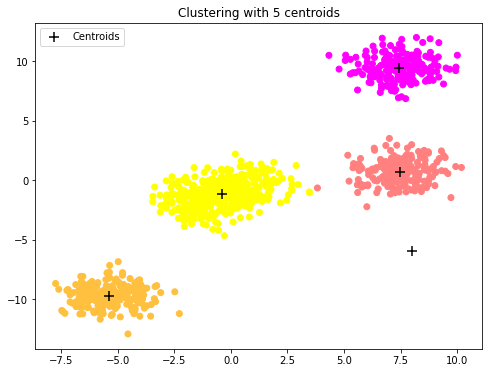

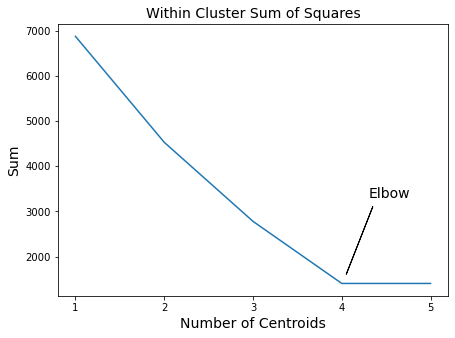

In [10]:
wcss = []
for i in range(1, 6):
    X_blob, y_blob = make_blobs(n_samples=1000, centers=5, n_features=2, random_state=8)
    model_blobs = KMeans(i)
    model_blobs.fit(X_blob)
    model_blobs.plot_clusters()
    wcss.append(model_blobs.wcss())
plt.figure(figsize=(7,5))
plt.plot(range(1,6), wcss)
plt.title('Within Cluster Sum of Squares', size = 14)
plt.xticks(range(1, 6))
plt.xlabel('Number of Centroids', size = 14)
plt.ylabel('Sum', size = 14)
plt.annotate('Elbow', (4.3, 3300), size = 14)
plt.arrow(4.05, wcss[3]+200, 0.3, 1500)
plt.show()

According to the plot above we can see how as k increases from 1 to 4, the within cluster sum of squares decreases and then flattens out after four creating an "elbow" shape and allowing us to conclude there are 4 clusters in our data. The within cluster sum of squares is the sum of distances for every point to their nearest centroid and is optimized if the centroid is in the middle of the cluster. The reason why we don't just use the smallest sum is because we could just make every point a centroid and then we would have a wcss of 0 but that wouldn't be helpful at all. 

Another issue with the out-of-the-box K-Means algorithm is that since the centroids are initialized randomly, sometimes they won't catch clusters even if we optimize everything else. 

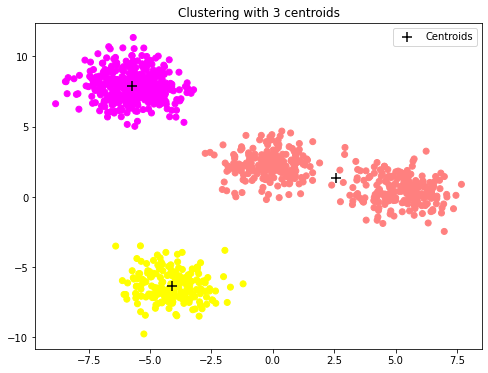

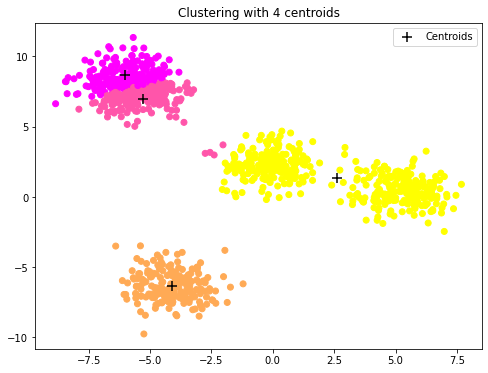

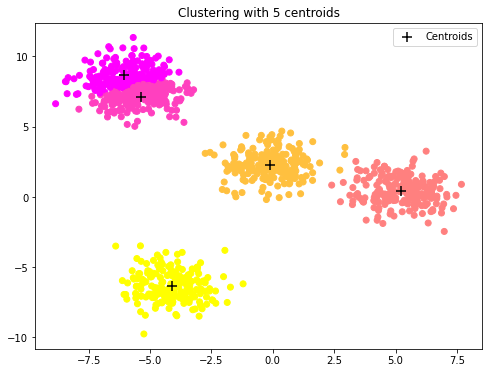

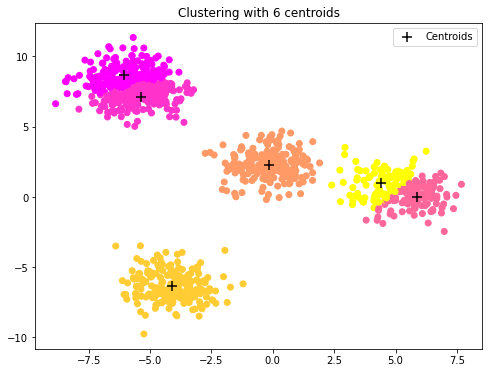

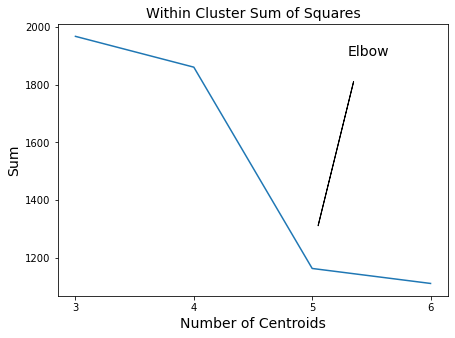

In [11]:
wcss = []
for i in range(3, 7):
    X_blob, y_blob = make_blobs(n_samples=1000, centers=5, n_features=2, random_state=5)
    model_blobs = KMeans(i)
    model_blobs.fit(X_blob)
    model_blobs.plot_clusters()
    wcss.append(model_blobs.wcss())
plt.figure(figsize=(7,5))
plt.plot(range(3,7), wcss)
plt.title('Within Cluster Sum of Squares', size = 14)
plt.xticks(range(3, 7))
plt.xlabel('Number of Centroids', size = 14)
plt.ylabel('Sum', size = 14)
plt.annotate('Elbow', (5.3, 1900), size = 14)
plt.arrow(5.05, wcss[3]+200, 0.3, 500)
plt.show()

Here is an example of using the elbow method to find the optimal k to minimize within cluster sum of squares which is five. However as humans, we have the advantage of seeing our data and in this case it has only four major clusters that our K-Means algorithm isn't picking up. In this case we would slightly adjust our K-Means algorithm by not randomizing our centroids, but rather systematically spreading them throughout the data. This approach is very common and is hence referred to as K-Means++.

## 2. K-Means++

The only adjustment from K-Means to K-Means++ has nothing to do with the clustering, but rather where we initialize our k centroids. Normally we would just throw k centroids at the data and call it a day but in K-Means++, we only randomly choose the first centroid by picking a random point from out data. We then place the  following centroids at the points in our data furthest away from all other existing centroids. The implementation looks something like this.  

In [12]:
class KMeansPP(KMeans):
#     self.num_centroids = k
#     self.max_iter = max_iter
     def init_centroids(self, X):
        self.centroids = [X[np.random.randint(0, len(X))]]
        while(len(self.centroids) < self.num_centroids):
            closest = []
            for x in X:
                dists = KMeansPP.euclidean(x, self.centroids)
                min_dist = np.min(dists)
                closest.append(min_dist)
            self.centroids.append(X[np.argmax(closest)])

Now that we have an implementation, let's see how these algorithms differ in practice using the previous dataset that K-Means failed at.

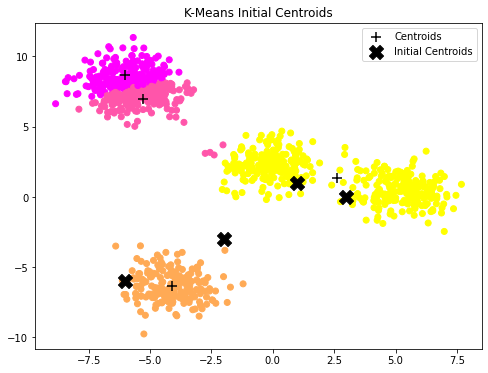

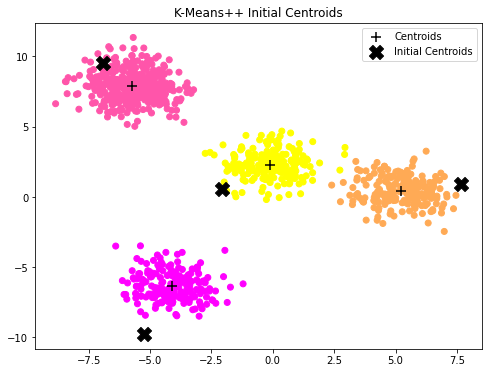

In [13]:
X_blob, y_blob = make_blobs(n_samples=1000, centers=5, n_features=2, random_state=5)

model_blobs = KMeans(4)
model_blobs.init_centroids(X_blob)
initial_centroids = np.array(model_blobs.centroids)
model_blobs.fit(X_blob)
model_blobs.plot_clusters()
plt.scatter(initial_centroids[:,0], initial_centroids[:, 1],
            c = 'black', s = 200, marker = 'X', label = 'Initial Centroids')
plt.legend()
plt.title('K-Means Initial Centroids')
plt.show()

model_plus = KMeansPP(4)
model_plus.init_centroids(X_blob)
initial_centroids_plus = np.array(model_plus.centroids)
model_plus.fit(X_blob)
model_plus.plot_clusters()
plt.scatter(initial_centroids_plus[:,0], initial_centroids_plus[:, 1],
            c = 'black', s = 200, marker = 'X', label = 'Initial Centroids')
plt.legend()
plt.title('K-Means++ Initial Centroids')
plt.show()

Just by looking at the initialized centroids for K-Means and K-Means++, we can see how K-Means++ systematically distributes the centroids to make sure all clusters are accounted for while K-Means fell more onto the right side of the data which ended up in the clusters not truly optimally clustering. 

### 2b. Runtime
When talking about runtime, K-Means is a very expensive algorithm. Since the distance between every point and every centroid need to be calculated for each iteration, the overall running time of K-Means is $O(nmk)$ with n points, k centroids, and m total operations. For K-Means++, its running time is $O(nm(k+1))$ 
since it runs each centroid when intializing them. Although on paper K-Means++ is slower than the standard K-Means, because of its systematic initialization, it converges a lot faster on top of being more accurate. K-Means also has a small probability of inifinitely bouncing around if a few points are in bad spots which further supports the usage of K-Means++.

## 3. Another Clustering Method: Spectral Clustering

Let's revisit the circular data that K-Means and K-Means++ failed to cluster correctly.

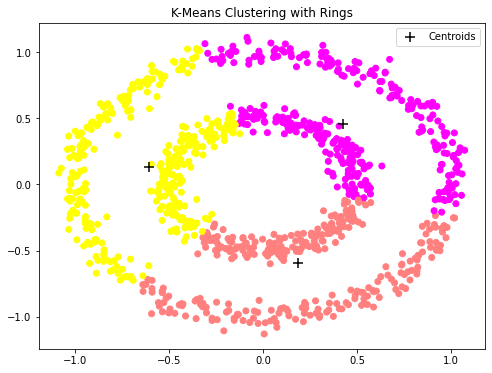

In [14]:
X_circle, y_circle = make_circles(n_samples=1000, noise=0.05, factor=0.5, random_state=171)
model_blobs = KMeans(3)
model_blobs.fit(X_circle)
model_blobs.plot_clusters()
plt.title('K-Means Clustering with Rings')
plt.show()

Looking back at the rings of data, we need a different kind of algorithm that will find these kinds of clusters that search by neighborhoods of points instead of slicing the space. This is where Spectral Clustering comes in.  Spectral Clustering clusters points based on how many neighbors it has within a certain distance. Below is a sample pseudo-code and an implementation using the data above as an example.

    Calculate distance from every point to every other point
    For each point:
        if point has at least n neighbors within d distance:
            label point and all neighbors the same

In [15]:
class Spectral:
    
    def __init__(self, eps, min_pts):
        self.num_clusters = 0
        self.eps = eps
        self.min_pts = min_pts
    
    def fit(self, X):
        self.original_data = X.copy()
        length = X.shape[0]
        self.labels = np.zeros(length)
        self.labels -= 1
        dists = np.zeros((length, length))
        dists += self.eps + 0.1 
        for i in range(length):
            for j in range(length):
                dists[i][j] = np.linalg.norm(X[i]-X[j])
        self.dists = dists
        for i in range(len(self.dists)):
            dis = self.dists[i] # distance row in dists matrix
            if(dis[dis<=self.eps].size > self.min_pts): # point i has more than required neighbors
                get_labels = self.labels[np.argwhere(dis<=self.eps).reshape(-1)] # get point labels
                if((get_labels>0).any()): # if any points are labeled already
                    label = min(get_labels[get_labels>0]) # get that label
                    other_label = max(get_labels[get_labels>0])
                    self.labels[np.argwhere(dis<=self.eps).reshape(-1)] = label
                    self.labels[np.argwhere(self.labels==other_label).reshape(-1)] = label
                else:
                    self.num_clusters+=1
                    self.labels[np.argwhere(dis<=self.eps).reshape(-1)] = self.num_clusters
            else: # No cluster
                self.num_clusters+=1 # iterate cliusters
                self.labels[i] = self.num_clusters # label point as noise
        
    def plot_clusters(self):
        plt.figure(figsize=(8,6))
        plt.scatter(self.original_data[:,0], self.original_data[:, 1], c=self.labels, cmap = 'spring')
        plt.title(f'Spectral Clustering')

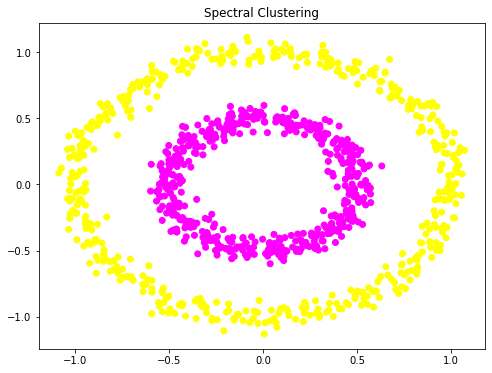

In [16]:
model = Spectral(0.2, 10)
model.fit(X_circle)
model.plot_clusters()

As we can see from the plot above, spectral clustering works really well with data that follows a non-linear pattern and in places where K-Means is ineffective.

## 4. Conclusion
There are many algorithms we can utilize in order to group our unlabeled data when doing unsupervised learning. Some other algorithms not covered in this notebook include DBSCAN and Hierarchical Clustering. Each algorithm has its strengths and weaknesses in terms of space, time, and complexity, but K-Means reigns as the most popular since it is the easier to implement, explain, and will usually perform well enough but can always be tweaked in small ways to make it much more accurate like in K-Means++. 